In [1]:
import talib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import datetime
import mplfinance as mpf

from Trader import Trader
from DivergenceDetector import DivergenceDetector

In [467]:
data_timeframe = '15min'

data_paths = [
    'data/2022/january/ethusdt.{timeframe}.1january2022-1february2022.csv'.format(timeframe=data_timeframe),
    'data/2022/february/ethusdt.{timeframe}.1-28feb2022.csv'.format(timeframe=data_timeframe),
    'data/2022/march/ethusdt.{timeframe}.1march2022-31march2022.csv'.format(timeframe=data_timeframe),
    'data/2022/april/ethusdt.{timeframe}.1april2022-22april2022.csv'.format(timeframe=data_timeframe)
]

df = pd.concat([pd.read_csv(d, index_col='Open time', usecols=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']) for d in data_paths])
df = df.drop_duplicates(keep='first')
df = df.dropna()

df.index = pd.to_datetime(df.index)
df = df.sort_values('Open time')

In [468]:
macd, macdsignal, macdhist = talib.MACD(df.Close, fastperiod=13, slowperiod=34, signalperiod=9)
atr = talib.ATR(df.High, df.Low, df.Close, timeperiod=14)
df = df.assign(macd=macd, macdsignal=macdsignal, atr=atr).dropna(axis=0)
df = df[df.index.month >= 2]

## Base Code

In [478]:
trader = Trader(leverage=1, fixed_margin=True, margin=0.1)

previous_macd = df.iloc[0].macd
previous_macdsignal = df.iloc[0].macdsignal

stoploss = None
rr = 1.5
tp = None

stoploss_count = 0
tp_count = 0

for idx, data in df.iloc[1:].iterrows():
    if trader.position == 'short':
        if data.High >= stoploss or data.Low <= tp:
            trader.close_pos(stoploss if data.High >= stoploss else tp, tp=tp, stoploss=stoploss, exit_date=idx)

            if data.High >= stoploss:
                stoploss_count += 1
            elif data.Low <= tp:
                tp_count += 1
                
            stoploss = None
            tp = None
    elif trader.position == 'long':
        if data.Low <= stoploss or data.High >= tp:
            trader.close_pos(stoploss if data.Low <= stoploss else tp, tp=tp, stoploss=stoploss, exit_date=idx)
            
            if data.Low <= stoploss:
                stoploss_count += 1
            elif data.High >= tp:
                tp_count += 1

            stoploss = None
            tp = None

    if trader.position == None:
        if (previous_macd < previous_macdsignal) & (data.macd > data.macdsignal): # long
            trader.open_pos(data.Close, 'long', 
                            entry_date = idx,
                            entry_macd = data.macd,
                            entry_macdsignal = data.macdsignal,
                            entry_previous_macd = previous_macd,
                            entry_previous_macdsignal = previous_macdsignal)
            stoploss = data.Close - data.atr
            tp = data.atr * rr + data.Close
        elif (previous_macd > previous_macdsignal) & (data.macd < data.macdsignal): # short
            trader.open_pos(data.Close, 'short', 
                            entry_date = idx,
                            entry_macd = data.macd,
                            entry_macdsignal = data.macdsignal,
                            entry_previous_macd = previous_macd,
                            entry_previous_macdsignal = previous_macdsignal)
            stoploss = data.Close + data.atr
            tp = data.Close - data.atr * rr 
    previous_macd = data.macd
    previous_macdsignal = data.macdsignal
    if trader.position != None:
        if trader.is_liquidated(data.Close):
            print('liquidated')
            break


In [479]:
result = pd.DataFrame(trader.history).set_index('entry_date')

win = result[result.percentage > 0]
print('TP count : ', tp_count)
print('SL count : ', stoploss_count)
print('Win rate : {:.2f}%'.format((len(win) / len(result) * 100)))
print('Long win rate : {:.2f}%'.format(len(win[win.position == 'long']) / len(win) * 100))
print('Short win rate : {:.2f}%'.format(len(win[win.position == 'short']) / len(win) * 100))

TP count :  190
SL count :  285
Win rate : 40.00%
Long win rate : 50.53%
Short win rate : 49.47%


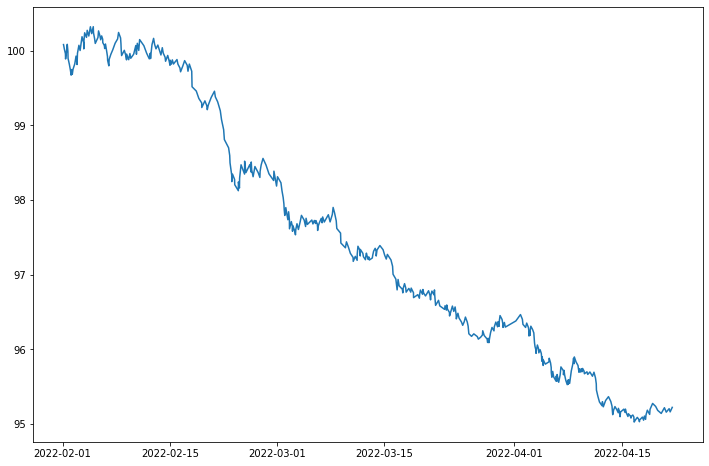

In [480]:
plt.figure(figsize=(12,8))
plt.plot(result.account_size)

In [481]:
result

,entry_price,position,entry_margin,entry_fee,number_contract,entry_macd,entry_macdsignal,entry_previous_macd,entry_previous_macdsignal,exit_price,profit,percentage,exit_fee,account_size,tp,stoploss,exit_date
entry_date,,,,,,,,,,,,,,,,,
2022-02-01 03:00:00,2739.51,long,10.0,0.004,0.003650,18.773938,16.836801,15.767947,16.352516,2763.992834,0.089369,0.008937,0.004,100.081369,2763.992834,2723.188111,2022-02-01 04:00:00
2022-02-01 05:45:00,2730.96,short,10.0,0.004,0.003662,22.784402,23.990158,24.335088,24.291597,2745.595826,-0.053592,-0.005359,0.004,100.019777,2709.006262,2745.595826,2022-02-01 08:00:00
2022-02-01 09:00:00,2783.81,long,10.0,0.004,0.003592,18.756825,16.781285,15.992322,16.287400,2769.198352,-0.052488,-0.005249,0.004,99.959289,2805.727473,2769.198352,2022-02-01 09:15:00
2022-02-01 09:30:00,2738.44,short,10.0,0.004,0.003652,16.646346,17.040472,18.569878,17.139004,2755.569023,-0.062550,-0.006255,0.004,99.888739,2712.746465,2755.569023,2022-02-01 11:15:00
2022-02-01 12:00:00,2765.66,long,10.0,0.004,0.003616,10.719400,10.548894,9.451218,10.506267,2791.549724,0.093611,0.009361,0.004,99.974350,2791.549724,2748.400184,2022-02-01 13:15:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-20 13:45:00,3101.98,short,10.0,0.004,0.003224,11.535114,14.347374,15.052945,15.050439,3075.809822,0.084366,0.008437,0.004,95.217475,3075.809822,3119.426785,2022-04-20 15:00:00
2022-04-20 19:30:00,3072.98,long,10.0,0.004,0.003254,-14.105195,-14.340811,-15.479577,-14.399715,3057.164367,-0.051467,-0.005147,0.004,95.158009,3096.703450,3057.164367,2022-04-20 20:15:00
2022-04-21 04:30:00,3082.04,short,10.0,0.004,0.003245,3.281245,3.609961,4.360363,3.692139,3065.225557,0.054556,0.005456,0.004,95.204565,3065.225557,3093.249628,2022-04-21 06:00:00


## Inverse Signal

In [456]:
trader = Trader(leverage=10, fixed_margin=False, margin=0.1)

previous_macd = df.iloc[0].macd
previous_macdsignal = df.iloc[0].macdsignal

stoploss = None
rr = 1
tp = None

stoploss_count = 0
tp_count = 0

for idx, data in df.iloc[1:].iterrows():
    if trader.position == 'short':
        if data.High >= stoploss or data.Low <= tp:
            trader.close_pos(stoploss if data.High >= stoploss else tp, tp=tp, stoploss=stoploss, exit_date=idx)

            if data.High >= stoploss:
                stoploss_count += 1
            if data.Low <= tp:
                tp_count += 1
                
            stoploss = None
            tp = None
    elif trader.position == 'long':
        if data.Low <= stoploss or data.High >= tp:
            trader.close_pos(stoploss if data.Low <= stoploss else tp, tp=tp, stoploss=stoploss, exit_date=idx)
            
            if data.Low <= stoploss:
                stoploss_count += 1
            if data.High >= tp:
                tp_count += 1

            stoploss = None
            tp = None

    if trader.position == None:
        if (previous_macd < previous_macdsignal) & (data.macd > data.macdsignal): # long
            trader.open_pos(data.Close, 'short', 
                            entry_date = idx,
                            entry_macd = data.macd,
                            entry_macdsignal = data.macdsignal,
                            entry_previous_macd = previous_macd,
                            entry_previous_macdsignal = previous_macdsignal)
            stoploss = data.Close + data.atr
            tp = data.Close - data.atr * rr
        elif (previous_macd > previous_macdsignal) & (data.macd < data.macdsignal): # short
            trader.open_pos(data.Close, 'long', 
                            entry_date = idx,
                            entry_macd = data.macd,
                            entry_macdsignal = data.macdsignal,
                            entry_previous_macd = previous_macd,
                            entry_previous_macdsignal = previous_macdsignal)
            stoploss = data.Close - data.atr
            tp = data.Close + data.atr * rr 
    previous_macd = data.macd
    previous_macdsignal = data.macdsignal
    if trader.position != None:
        if trader.is_liquidated(data.Close):
            print('liquidated')
            break


In [457]:
result = pd.DataFrame(trader.history).set_index('entry_date')

win = result[result.percentage > 0]
print('Win rate : {:.2f}%'.format((len(win) / len(result) * 100)))
print('Long win rate : {:.2f}%'.format(len(win[win.position == 'long']) / len(win) * 100))
print('Short win rate : {:.2f}%'.format(len(win[win.position == 'short']) / len(win) * 100))

Win rate : 47.28%
Long win rate : 51.11%
Short win rate : 48.89%


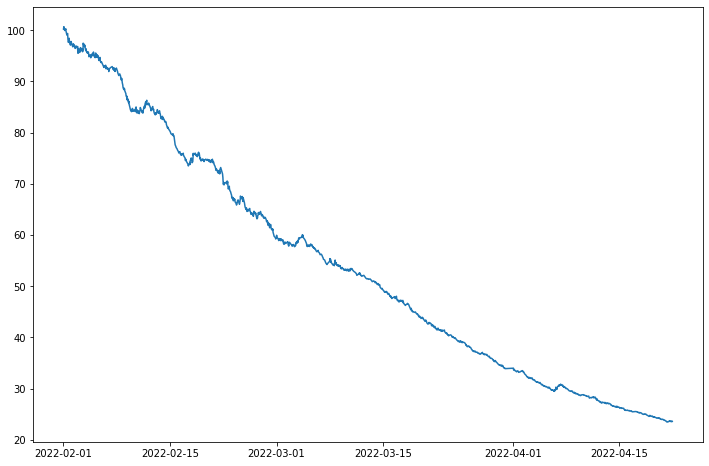

In [458]:
plt.figure(figsize=(12,8))
plt.plot(result.account_size)

## Param Search

In [209]:
data_paths = [
    'data/2022/january/ethusdt.1hour.1january2022-1february2022.csv',
    'data/2022/february/ethusdt.1hour.1-28feb2022.csv',
    'data/2022/march/ethusdt.1hour.1march2022-21march2022.csv'
]

df = pd.concat([pd.read_csv(d, index_col='Open time', usecols=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']) for d in data_paths])
df = df.drop_duplicates(keep='first')
df = df.dropna()

df.index = pd.to_datetime(df.index)
df = df.sort_values('Open time')

In [210]:
slowperiod = np.arange(20,40,5)
fastperiod = np.arange(5,20,3)
signalperiod = np.arange(5,20, 3)
atrperiod = np.arange(5,20,3)

In [211]:
history = []
for fastp in fastperiod:
    print(fastp)
    for slowp in slowperiod:
        for signalp in signalperiod:
            for atrp in atrperiod:
                macd, macdsignal, macdhist = talib.MACD(df.Close, fastperiod=fastp, slowperiod=slowp, signalperiod=signalp)
                atr = talib.ATR(df.High, df.Low, df.Close, timeperiod=atrp)
                df_tmp = df.assign(macd=macd, macdsignal=macdsignal, atr=atr).dropna(axis=0)
                df_tmp = df_tmp[df_tmp.index.month == 2]
                
                trader = Trader(leverage=1)

                previous_macd = df_tmp.iloc[0].macd
                previous_macdsignal = df_tmp.iloc[0].macdsignal

                stoploss = None
                rr = 2
                tp = None

                for idx, data in df_tmp.iloc[1:].iterrows():
                    if trader.position == 'short':
                        if data.Close >= stoploss or data.Close <= tp:
                            trader.close_pos(stoploss if data.Close >= stoploss else tp, exit_date=idx,
                                 exit_macd = data.macd,
                                 exit_macdsignal = data.macdsignal,
                                 exit_previous_macd = previous_macd,
                                 exit_previous_macdsignal = previous_macdsignal)
                            stoploss = None
                            tp = None
                    elif trader.position == 'long':
                        if data.Close <= stoploss or data.Close >= tp:
                            trader.close_pos(stoploss if data.Close >= stoploss else tp, exit_date=idx,
                                 exit_macd = data.macd,
                                 exit_macdsignal = data.macdsignal,
                                 exit_previous_macd = previous_macd,
                                 exit_previous_macdsignal = previous_macdsignal)
                            stoploss = None
                            tp = None

                    if trader.position == None:
                        if (previous_macd < previous_macdsignal) & (data.macd > data.macdsignal): # long
                            trader.open_pos(data.Close, 'long', 
                                            entry_date = idx,
                                            entry_macd = data.macd,
                                            entry_macdsignal = data.macdsignal,
                                            entry_previous_macd = previous_macd,
                                            entry_previous_macdsignal = previous_macdsignal)
                            stoploss = data.Close - data.atr
                            tp = data.atr * rr + data.Close
                        elif (previous_macd > previous_macdsignal) & (data.macd < data.macdsignal): # short
                            trader.open_pos(data.Close, 'short', 
                                            entry_date = idx,
                                            entry_macd = data.macd,
                                            entry_macdsignal = data.macdsignal,
                                            entry_previous_macd = previous_macd,
                                            entry_previous_macdsignal = previous_macdsignal)
                            stoploss = data.Close + data.atr
                            tp = data.Close - data.atr * rr 
                    previous_macd = data.macd
                    previous_macdsignal = data.macdsignal
                history.append([fastp, slowp, signalp, atrp, trader.account_size])
            print('Maximum percentage = ', np.max(np.array(history)[:, 4]))

5
Maximum percentage =  103.79356081037703
Maximum percentage =  103.79356081037703
Maximum percentage =  103.79356081037703
Maximum percentage =  103.79356081037703
Maximum percentage =  103.79356081037703
Maximum percentage =  103.93011207178708
Maximum percentage =  103.93011207178708
Maximum percentage =  103.93011207178708
Maximum percentage =  103.93011207178708
Maximum percentage =  103.93011207178708
Maximum percentage =  103.93011207178708
Maximum percentage =  103.93011207178708
Maximum percentage =  103.93011207178708
Maximum percentage =  103.93011207178708
Maximum percentage =  104.15158513325059
Maximum percentage =  104.15158513325059
Maximum percentage =  104.15158513325059
Maximum percentage =  104.15158513325059
Maximum percentage =  104.15158513325059
Maximum percentage =  104.15158513325059
8
Maximum percentage =  104.15158513325059
Maximum percentage =  104.15158513325059
Maximum percentage =  104.15158513325059
Maximum percentage =  104.15158513325059
Maximum perc

In [212]:
tmp_ema2 = pd.DataFrame(history)
tmp_ema2 = tmp_ema2[tmp_ema2[4] > 100]

In [213]:
tmp_ema2.sort_values(2, ascending=False).head(30)

,0,1,2,3,4
499,17,35,17,17,100.615368
172,8,30,17,11,103.466237
99,5,35,17,17,103.127864
98,5,35,17,14,102.876954
97,5,35,17,11,103.700270
96,5,35,17,8,103.748018
95,5,35,17,5,103.433007
174,8,30,17,17,103.589786
345,14,25,17,5,101.426484
346,14,25,17,8,101.301952


In [214]:
data_paths = [
    'data/2022/january/ethusdt.1hour.1january2022-1february2022.csv',
    'data/2022/february/ethusdt.1hour.1-28feb2022.csv',
    'data/2022/march/ethusdt.1hour.1march2022-21march2022.csv'
]

df = pd.concat([pd.read_csv(d, index_col='Open time', usecols=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']) for d in data_paths])
df = df.drop_duplicates(keep='first')
df = df.dropna()

df.index = pd.to_datetime(df.index)
df = df.sort_values('Open time')

In [215]:
macd, macdsignal, macdhist = talib.MACD(df.Close, fastperiod=17, slowperiod=35, signalperiod=17)
atr = talib.ATR(df.High, df.Low, df.Close, timeperiod=17)
df = df.assign(macd=macd, macdsignal=macdsignal, atr=atr).dropna(axis=0)
df = df[df.index.month == 3]

In [216]:
trader = Trader(leverage=10)

previous_macd = df.iloc[0].macd
previous_macdsignal = df.iloc[0].macdsignal

stoploss = None
rr = 2
tp = None

for idx, data in df.iloc[1:].iterrows():
    if trader.position == 'short':
        if data.Close >= stoploss or data.Close <= tp:
            trader.close_pos(stoploss if data.Close >= stoploss else tp, exit_date=idx,
                 exit_macd = data.macd,
                 exit_macdsignal = data.macdsignal,
                 exit_previous_macd = previous_macd,
                 exit_previous_macdsignal = previous_macdsignal)
            stoploss = None
            tp = None
    elif trader.position == 'long':
        if data.Close <= stoploss or data.Close >= tp:
            trader.close_pos(stoploss if data.Close >= stoploss else tp, exit_date=idx,
                 exit_macd = data.macd,
                 exit_macdsignal = data.macdsignal,
                 exit_previous_macd = previous_macd,
                 exit_previous_macdsignal = previous_macdsignal)
            stoploss = None
            tp = None
    
    if trader.position == None:
        if (previous_macd < previous_macdsignal) & (data.macd > data.macdsignal): # long
            trader.open_pos(data.Close, 'long', 
                            entry_date = idx,
                            entry_macd = data.macd,
                            entry_macdsignal = data.macdsignal,
                            entry_previous_macd = previous_macd,
                            entry_previous_macdsignal = previous_macdsignal)
            stoploss = data.Close - data.atr
            tp = data.atr * rr + data.Close
        elif (previous_macd > previous_macdsignal) & (data.macd < data.macdsignal): # short
            trader.open_pos(data.Close, 'short', 
                            entry_date = idx,
                            entry_macd = data.macd,
                            entry_macdsignal = data.macdsignal,
                            entry_previous_macd = previous_macd,
                            entry_previous_macdsignal = previous_macdsignal)
            stoploss = data.Close + data.atr
            tp = data.Close - data.atr * rr 
    previous_macd = data.macd
    previous_macdsignal = data.macdsignal

In [217]:
result

,entry_price,position,entry_margin,entry_fee,number_contract,entry_macd,entry_macdsignal,entry_previous_macd,entry_previous_macdsignal,exit_price,profit,percentage,exit_fee,account_size,exit_date,exit_macd,exit_macdsignal,exit_previous_macd,exit_previous_macdsignal
entry_date,,,,,,,,,,,,,,,,,,,
2022-03-01 21:00:00,2954.42,short,10.000000,0.040000,0.033848,48.934518,50.038023,50.313574,50.175961,3002.952993,-1.642725,-0.164272,0.040000,98.277275,2022-03-02 03:00:00,42.483371,46.997742,40.485009,47.562038
2022-03-05 06:00:00,2624.28,long,9.827728,0.039311,0.037449,-51.342488,-52.437347,-53.210159,-52.574204,2685.669729,2.298998,0.233930,0.039311,100.497652,2022-03-06 23:00:00,-15.289171,-14.036657,-11.562424,-13.880093
2022-03-06 23:00:00,2549.37,short,10.049765,0.040199,0.039421,-15.289171,-14.036657,-11.562424,-13.880093,2577.374934,-1.103971,-0.109850,0.040199,99.313283,2022-03-07 13:00:00,-23.735424,-26.043914,-29.071070,-26.332475
2022-03-07 13:00:00,2618.99,long,9.931328,0.039725,0.037920,-23.735424,-26.043914,-29.071070,-26.332475,2679.242876,2.284816,0.230061,0.039725,101.518648,2022-03-07 17:00:00,-13.037231,-21.957273,-13.575984,-23.072278
2022-03-07 20:00:00,2466.17,short,10.151865,0.040607,0.041164,-24.151877,-21.445533,-20.345023,-21.107240,2503.012275,-1.516594,-0.149391,0.040607,99.920840,2022-03-07 22:00:00,-26.778855,-22.516952,-26.293669,-21.984214
2022-03-08 02:00:00,2546.10,long,9.992084,0.039968,0.039245,-23.208206,-23.694671,-25.668545,-23.755480,2505.960418,-1.575264,-0.157651,0.039968,98.265639,2022-03-09 03:00:00,14.555978,1.212029,8.294285,-0.455964
2022-03-09 21:00:00,2706.69,short,9.826564,0.039306,0.036305,34.971158,36.516883,37.214047,36.710098,2637.193764,2.523042,0.256757,0.039306,100.710068,2022-03-10 04:00:00,12.157489,29.097505,18.450675,31.215007
2022-03-11 09:00:00,2599.27,long,10.071007,0.040284,0.038746,-15.101341,-16.013823,-16.778017,-16.127883,2659.306194,2.326134,0.230973,0.040284,102.955633,2022-03-11 16:00:00,-7.187900,-10.743113,-5.106025,-11.187515
2022-03-11 19:00:00,2556.16,short,10.295563,0.041182,0.040277,-11.495148,-10.590752,-10.242962,-10.477702,2587.893663,-1.278151,-0.124146,0.041182,101.595117,2022-03-12 05:00:00,-7.695997,-10.742770,-8.802464,-11.123617


In [218]:
result = pd.DataFrame(trader.history).set_index('entry_date')

win = result[result.percentage > 0]
print('Win rate : {:.2f}%'.format((len(win) / len(result) * 100)))
print('Long win rate : {:.2f}%'.format(len(win[win.position == 'long']) / len(win) * 100))
print('Short win rate : {:.2f}%'.format(len(win[win.position == 'short']) / len(win) * 100))

Win rate : 36.84%
Long win rate : 85.71%
Short win rate : 14.29%


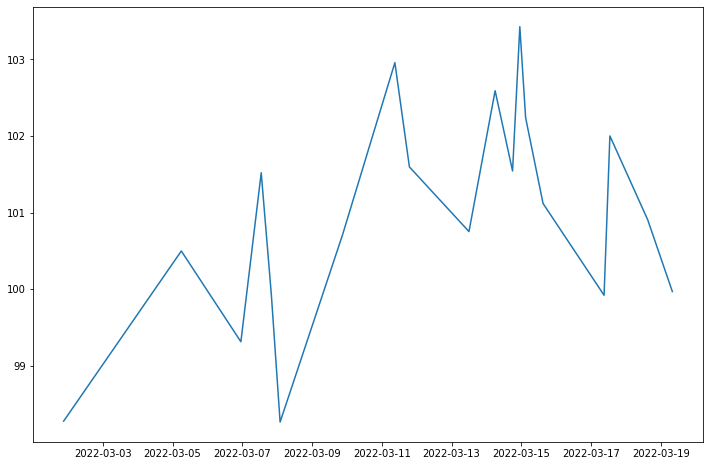

In [219]:
plt.figure(figsize=(12,8))
plt.plot(result.account_size)